In [2]:
"""
Apply on UA-DETRAC Dataset

"""
%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import h5py

import sys


from sklearn.cluster import KMeans


os.environ["CUDA_VISIBLE_DEVICES"]="0"

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [3]:
os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'train_images')
data_dir

'/Users/azwreith/Documents/Eva/data/ua_detrac/train_images'

In [4]:
def load_images_nn(image_dir, downsize_rate = 1):
    """
    Loading images in a non normalized form
    :param image_dir:
    :param downsize_rate:
    :param grayscale:
    :return:
    """
    image_height = 540
    image_width = 960
    file_names = []
    print(image_dir)
    #tmp = '/nethome/jbang36/eva/data/ua_detrac'
    mvi_dir = os.listdir(image_dir)
    mvi_dir.sort()
    
    for mvi in mvi_dir:
        if mvi == "README.md" or mvi == "download.sh" or mvi == "unzip.sh":
            continue
        image_files = os.listdir(os.path.join(image_dir, mvi))
        image_files.sort()
        for image_file in image_files:
            file_names.append(os.path.join(image_dir, mvi, image_file))
        
    print("Length of file_names", len(file_names))
    print(file_names[0])

    
    img_table = np.ndarray(shape=(len(file_names), int(image_height / downsize_rate), int(image_width / downsize_rate)))
    
    for i in range(len(file_names)):
        file_name = file_names[i]
        img = cv2.imread(file_name,0)
        img = cv2.resize(img, (image_width // downsize_rate, image_height // downsize_rate))
        img_table[i] = img

    return img_table

image_table = load_images_nn(data_dir, downsize_rate = 12)

/Users/azwreith/Documents/Eva/data/ua_detrac/train_images
Length of file_names 6021
/Users/azwreith/Documents/Eva/data/ua_detrac/train_images/MVI_20011/img00001.jpg


In [5]:
# split the training and test data
image_table = image_table[:,:,:,np.newaxis]

n_samples = image_table.shape[0]
train_x = image_table[:int(n_samples * 0.8)]
test_x = image_table[int(n_samples * 0.8):]

In [6]:
image_table.shape

(6021, 45, 80, 1)

(45, 80, 1)
(45, 80)
(45, 80)


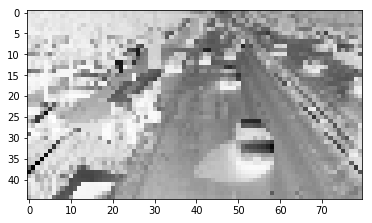

In [7]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(train_x[image_index].shape)

example = train_x[image_index]
width, height, channels = example.shape
example = np.squeeze(example)
print(np.squeeze(example).shape)
print(example.shape)

plt.imshow(example, cmap='Greys')

In [8]:
# Must perform normalization for the autoencoder to perform well
train_x /= 255.0
test_x /= 255.0 

In [9]:
keras.backend.clear_session()

In [15]:
# Combined network with both FC and CNN layers

n_samples, width, height, channels = train_x.shape
# Input
input_img = Input(shape=(width, height, 1))
# Encoder
x = Conv2D(8,(3,3),
           activation='relu',
           padding='same')(input_img)
x = Conv2D(8,(3,3),
           activation='relu',
           padding='same')(x)
x = MaxPooling2D((2,2),
                 padding='same')(x) 
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same')(x)
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same')(x)
encoded = MaxPooling2D((2,2),
                 padding='same', name='encoded')(x)
# Decoder
x = Conv2D(16, (3, 3),
           activation='relu',
           padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3),
           activation='relu',
           padding='same')(x)
x = Conv2D(16, (3, 3),
           activation='relu',
           padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3),
           activation='relu',
           padding='same')(x)
x = Conv2D(1, (3, 3),
           activation='relu',
           padding='same')(x)

decoded = Cropping2D(cropping=((2,1),(0,0)),
               data_format='channels_last')(x) # size 45, 80, 16


autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 45, 80, 1)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 45, 80, 8)         80        
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 45, 80, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 40, 8)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 23, 40, 16)        1168      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 23, 40, 16)        2320      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 12, 20, 16)        0         
__________

In [16]:
start_time = time.time()
train_history = autoencoder.fit(train_x, train_x, epochs=200, batch_size=2048, validation_data=(test_x, test_x))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")

Instructions for updating:
Use tf.cast instead.
Train on 4816 samples, validate on 1205 samples
Epoch 1/200
4816/4816 [==============================] - 52s 11ms/step - loss: 0.2434 - val_loss: 0.2438
Epoch 2/200
4816/4816 [==============================] - 46s 10ms/step - loss: 0.2280 - val_loss: 0.2098
Epoch 3/200
4816/4816 [==============================] - 53s 11ms/step - loss: 0.1855 - val_loss: 0.1282
Epoch 4/200
4816/4816 [==============================] - 52s 11ms/step - loss: 0.0945 - val_loss: 0.0422
Epoch 5/200
4816/4816 [==============================] - 60s 12ms/step - loss: 0.0622 - val_loss: 0.0543
Epoch 6/200
4816/4816 [==============================] - 67s 14ms/step - loss: 0.0427 - val_loss: 0.0423
Epoch 7/200
4816/4816 [==============================] - 55s 11ms/step - loss: 0.0429 - val_loss: 0.0525
Epoch 8/200
4816/4816 [==============================] - 59s 12ms/step - loss: 0.0473 - val_loss: 0.0415
Epoch 9/200
4816/4816 [==============================] - 59s 12m

In [17]:
# save the trained model
autoencoder.save('indexing_detrac_autoencoder.h5')

In [20]:
from keras.models import load_model
start_time = time.time()
autoencoder = load_model('indexing_detrac_autoencoder.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded').output)
print('Model loaded in: ', time.time() - start_time)

Model loaded in:  2.791694164276123


In [33]:
# encode database of images
codes = encoder.predict(train_x)

codes = codes.reshape(-1, 12*20*16)

# train for closest images using nearest neighbour
from sklearn.neighbors import NearestNeighbors
k = 5
knn = NearestNeighbors(n_neighbors=k).fit(codes)

print(codes.shape)

(4816, 3840)


Query Images:


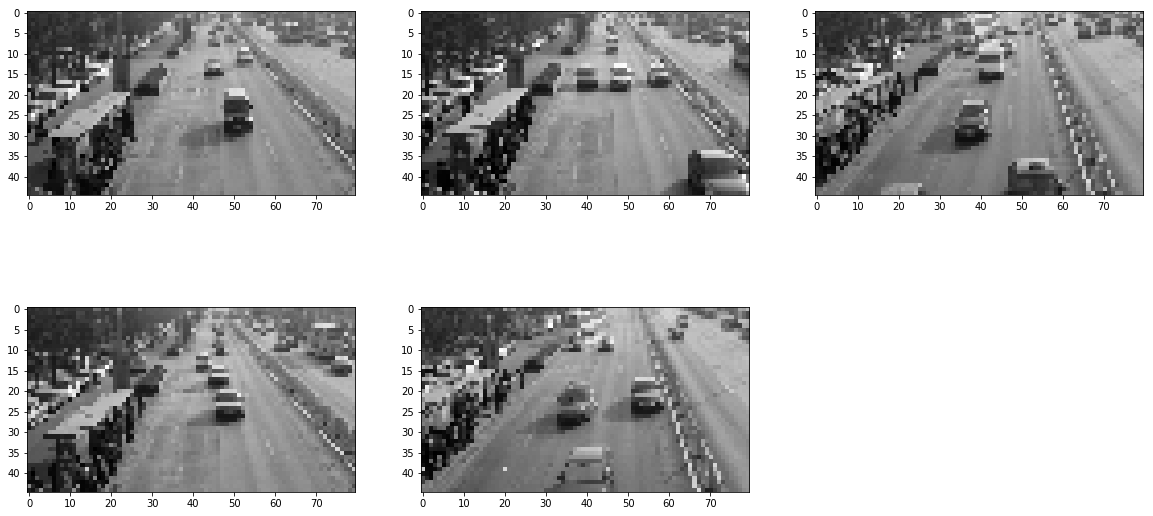

In [35]:
query_indices = np.random.randint(test_x.shape[0], size=5)
query_images = test_x[query_indices]
fig=plt.figure(figsize=(20, 10))
columns = 3
rows = 2
print("Query Images:")
for idx, image in enumerate(query_images):
    fig.add_subplot(rows, columns, idx + 1)
    plt.imshow(np.squeeze(image), cmap="gray")
plt.show()

In [36]:
query_codes = encoder.predict(query_images)
query_codes = query_codes.reshape(-1, 12*20*16)
print(query_codes.shape)

(5, 3840)


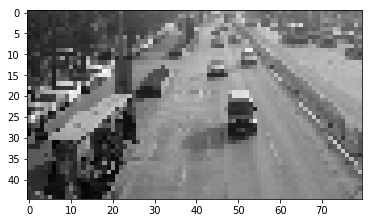

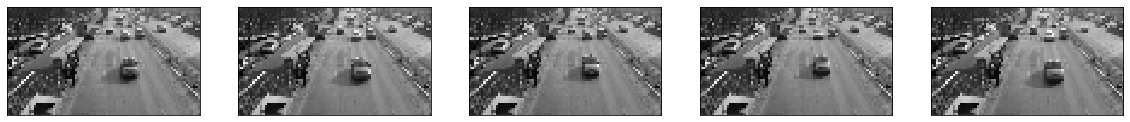

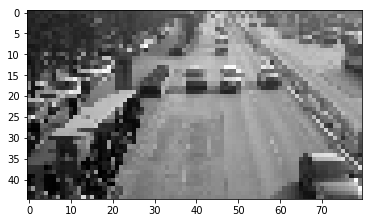

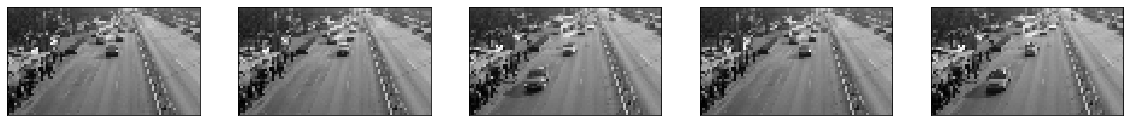

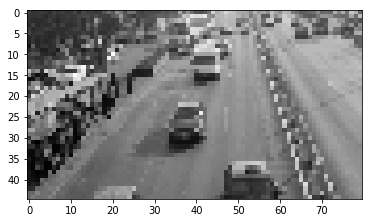

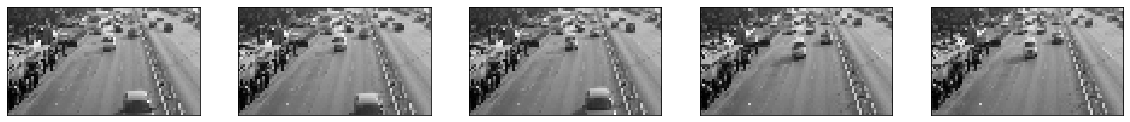

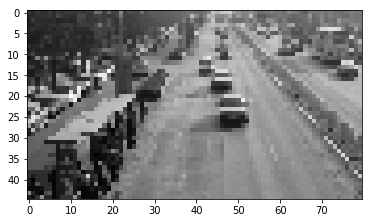

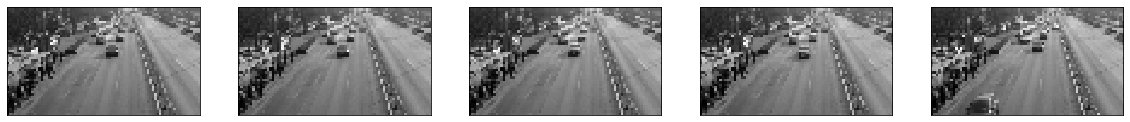

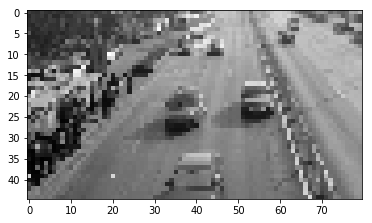

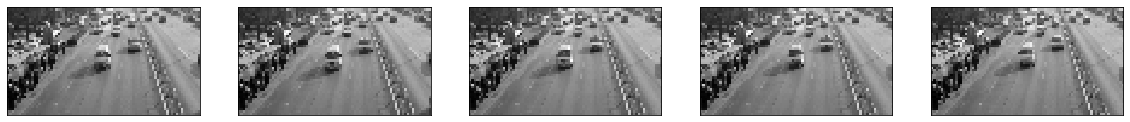

In [40]:
distances, indices = knn.kneighbors(query_codes)
for i in range(len(query_codes)):
    closest_images = train_x[indices[i]]
    plt.imshow(np.squeeze(query_images[i]), cmap='gray')
    plt.figure(figsize=(20, 6))
    for j in range(k):
        ax = plt.subplot(1, k, j+1)
        plt.imshow(np.squeeze(closest_images[j]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()